<font color='blue'> **w_plot_02_map_view_example** </font>   w05_freyberg

In [1]:
import os; import sys; from pathlib import Path; from pprint import pformat ; from shutil import copytree    ; import matplotlib as mpl ; 
import matplotlib.pyplot as plt ; import numpy as np ; import pandas as pd; import shapefile ; import flopy  ; from os.path import join; import csv 
from flopy.mf6 import MFSimulation ; from flopy.utils import PathlineFile ; from flopy.export.vtk import Vtk ; import pyvista as pvv
from IPython.core.display import Image

In [2]:
mdl_name = "freyberg";  sim_path = Path('E:\\15_REPOS\\00_BETAMI\\bin\\Flopy_data\\mf6-freyberg')                  ; sim_name = mdl_name
sim_ws = workspace    = model_ws = Path('E:\\15_REPOS\\00_BETAMI\\94_floPy\\05_VTK') ; sim_ws.mkdir(exist_ok=True) ; exe_name = "mf6"

In [3]:
sim = MFSimulation.load(sim_name = sim_name, sim_ws = sim_path, verbosity_level=0)
sim.set_sim_path(workspace) ; sim.write_simulation() ; sim.run_simulation(silent=True, report=False)

(True, [])

In [4]:
pgs = [] ; gwf = sim.get_model(mdl_name)
for i in range(1, 5):  # 11
    nrow = gwf.modelgrid.nrow                ;     ncol = gwf.modelgrid.ncol
    m = i * 2 if i < 3 else (nrow - i * 4)   ;     n = i * 2 if i < 3 else (ncol - i * 4) ; lrcregions = [[[0, m, n, 0, m + 1, n + 1]]]
    celldata = flopy.modpath.CellDataType        (drape=0, columncelldivisions=1   , rowcelldivisions = 1  , layercelldivisions=1)
    lrcpd = flopy.modpath.LRCParticleData        ( subdivisiondata=[celldata]      , lrcregions   = lrcregions)
    pg = flopy.modpath.ParticleGroupLRCTemplate  (particlegroupname=f"PG{i}" , particledata = lrcpd ,filename=f"{sim_name}.pg{i}.sloc") ; pgs.append(pg)

In [5]:
print('nrow',nrow,'ncol',ncol) ; np.savetxt(sim_ws / "01_lrcregions.csv", lrcregions[0], delimiter=",")  ; print('lrcregions      ',lrcregions[0]) 
wel_locs=[(rec[0][1], rec[0][2]) for rec in (gwf.wel.stress_period_data.data[0])]       
np.savetxt(sim_ws / "02_wel_locs.csv", wel_locs, delimiter=",")                                         ; print('wel_locs.csv',wel_locs)

nrow 40 ncol 20
lrcregions       [[0, 24, 4, 0, 25, 5]]
wel_locs.csv [(8, 15), (10, 12), (19, 13), (25, 9), (28, 5), (33, 11)]


In [6]:
mp    = flopy.modpath.Modpath7    (modelname = f"{sim_name}_mp" ,flowmodel = gwf ,exe_name = "mp7" ,model_ws = workspace)
mpbas = flopy.modpath.Modpath7Bas (mp ,porosity = 0.1)
mpsim = flopy.modpath.Modpath7Sim (mp ,simulationtype = "combined" ,trackingdirection = "forward" ,budgetoutputoption = "summary" ,
                                  referencetime = [0,0,0.0] ,timepointdata = [1,[0]] ,zonedataoption = "on" ,particlegroups = pgs)
mp.write_input(); mp.run_model(silent=True, report=False)

(True, [])

In [7]:
head = flopy.utils.HeadFile(workspace / f"{mdl_name}.hds") ; heads = head.get_data()   
pff = PathlineFile(workspace / mpsim.pathlinefilename)     ; pll = pff.get_alldata() ## must come from another simulation ...
#pll = pff.get_destination_pathline_data(nodew, to_recarray=True)

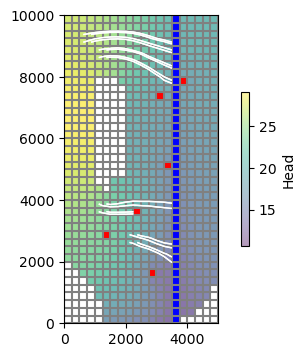

In [9]:
fig = plt.figure(figsize=(6, 4))        ; ax = fig.add_subplot(1, 1, 1, aspect="equal")       # ; mv.plot_ibound() 
mv = flopy.plot.PlotMapView(model=gwf)  ; mv.plot_grid()                    ; hdd = mv.plot_array(heads, alpha=0.4)      
cb = plt.colorbar(hdd, shrink=0.5)      ; cb.set_label("Head")              ; mv.plot_bc("RIV",color='blue') ; mv.plot_bc("WEL",color='red') 
mv.plot_pathline(pll, layer="all"       , alpha=1, colors=["white"], lw=1)  ; plt.show()

In [10]:
vtk = Vtk(model=gwf, binary=False, vertical_exageration=50, smooth=False) ; vtk.add_model(gwf) ; vtk.add_pathline_points(pll)
grid, pathlines = vtk.to_pyvista()                    ; axes = pvv.Axes(show_actor=True, actor_scale=2.0, line_width=5)
grid.rotate_z(160, point=axes.origin, inplace=True)   ; pathlines.rotate_z(160, point=axes.origin, inplace=True)
assert grid.n_cells == gwf.modelgrid.nnodes ; print("Model grid has", grid.n_cells, "cells") ; print("Model grid has", grid.n_arrays, "arrays")

Model grid has 800 cells
Model grid has 9 arrays


**manual pathlines conctruction ...    pathlines may also be read directly from the MODPATH 7 pathline output file `pathline` or `combined` mode**






In [11]:
tracks = {} ; particle_ids = set() ; release_locs = list()
for i, t in enumerate(pathlines["time"]):
    pid = str(round(float(pathlines["particleid"][i])))   ; loc = pathlines.points[i]
    if pid not in tracks:
        tracks[pid] = [] ;         particle_ids.add(pid)  ; release_locs.append(loc)
    tracks[pid].append((loc, t))
release_locs = np.array(release_locs) 
tracks = {k: np.array(v, dtype=object) for k, v in tracks.items()}
max_track_len = max([len(v)            for    v in tracks.values()]);  print("The maximum number of locations per particle track is", max_track_len)

The maximum number of locations per particle track is 18


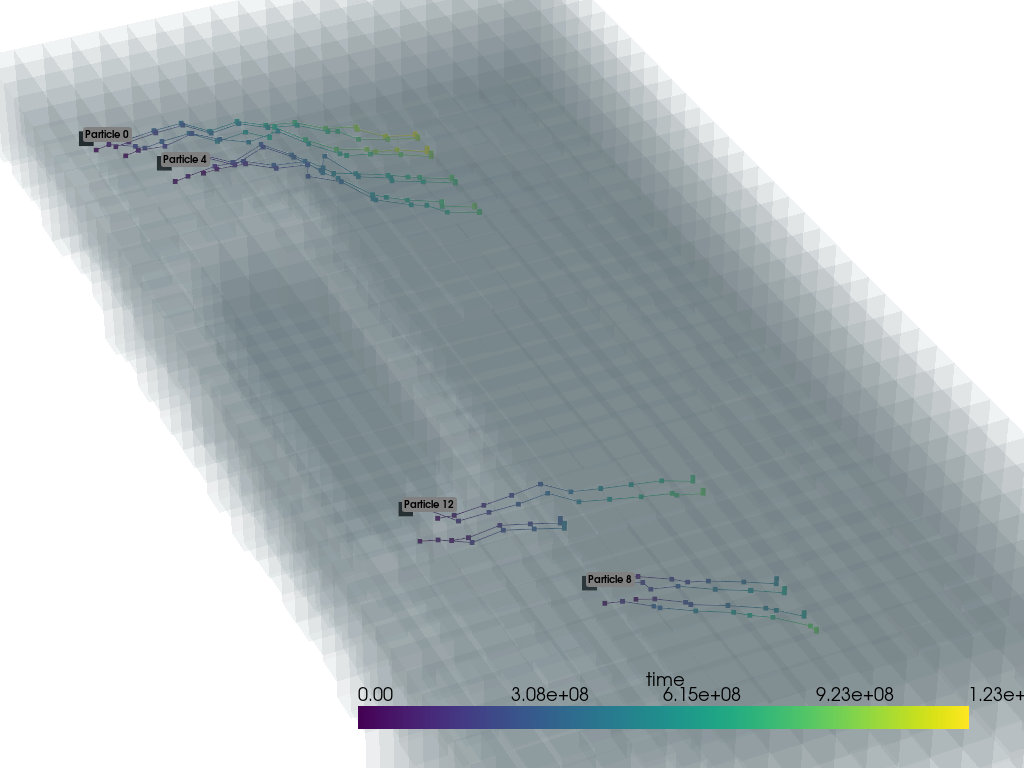

In [12]:
pvv.set_plot_theme("document") ; pvv.set_jupyter_backend("static")
ppp = pvv.Plotter() ; ppp.add_mesh(grid, opacity=0.05) ; ppp.add_mesh(pathlines, scalars="time")
label_coords = [] ; start_labels = []
for pid, track in tracks.items():
    if int(pid) % 4 == 0:
        label_coords.append(track[0][0]) ; start_labels.append(f"Particle {pid}")
ppp.add_point_labels(label_coords,start_labels,font_size=10,point_size=15,point_color="black") ; ppp.camera.zoom(2.4) ; ppp.show()